In [2]:
import re
import numpy as np
import pandas as pd
import sklearn
import matplotlib
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
import nltk
# sklearn
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from collections import Counter
from PIL import Image
from wordcloud import WordCloud,ImageColorGenerator
import urllib
import requests

In [3]:
print(sklearn.__version__)
print(matplotlib.__version__)
print(np.__version__)
print(pd.__version__)
print(nltk.__version__)

0.23.1
3.1.3
1.18.1
1.0.1
3.7


In [4]:
file_name='dataset.csv'
data = pd.read_csv(file_name, sep = ',',names = ['text','username','location'])
data.shape

(131563, 3)

In [5]:
data.head()

,text,username,location
0,RT @tsum_africa: In response to the current #C...,PaulABarter,Singapore
1,RT @FemAdesina: No presidential broadcast on C...,Abdulazizmento2,port Harcourt
2,Covid-19 Outbreak in Nigeria Is Just One of Af...,Ricardo_Gardel,"Tinton Falls, NJ"
3,RT @ChangeOrg_India: Walking miles without foo...,ahumanenough,NaN
4,RT @GhulamABilour: I have been tested positive...,tormakhay_s,"Sexi, Peru"


In [6]:
#dropping Empty Rows
data=data[(data['location'].notnull())] 
#Resetting index
data = data.sample(frac=1).reset_index(drop=True)
#removing Clip tweets
data['len']=data["text"].str.len()                          
df1= data[(data['len'] <=137)]
df2=data[(data['len'] >=150)]
#concatinating two Dataframes
data=pd.concat([df1,df2])  
#resetting Index
data = data.sample(frac=1).reset_index(drop=True)       

In [7]:
data.shape

(35482, 4)

In [8]:
data.head()

,text,username,location,len
0,RT @newscientist: Covid-19 pandemic risks wors...,khamaadory,Ubiquitous,125
1,RT @jgopikrishnan70: FDA suspends Bill Gates-b...,AbhinavAgarwal,"Bengaluru, India",108
2,#Smallbusinesses are scrambling to gain a foot...,PHILIPmANDERSON,"Coeur d'Alene, ID",273
3,@NCDCgov @NOA_Nigeria @Fmohnigeria @FMICNigeri...,ubaha,"Lagos State, Nigeria",377
4,Western capitals aren't just worried about the...,zusolms,Bad Homburg,229


In [9]:
#Data Preprocessing 
#In the above-given problem statement before training the model, we have performed various pre-processing steps on the 
#dataset that mainly dealt with removing stopwords, removing emojis. The text document is then converted into the lowercase
#for better generalization.

#Subsequently, the punctuations were cleaned and removed thereby reducing the unnecessary noise from the dataset.
#After that, we have also removed the repeating characters from the words along with removing the URLs as they do not 
#have any significant importance.

#function to remove pattern 
def remove_pattern(input_txt, pattern):                                          
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

# removing RT @x from tweets:
# removing  @xxx from tweets:
# removing URL links http://xxx

def clean_tweets(lst):
    lst = np.vectorize(remove_pattern)(lst, "\r")                                  
    lst = np.vectorize(remove_pattern)(lst, "\n")
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")                         
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")                             
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")            
    return lst

In [10]:
#Cleaned Tweets are kept in separate coloumn
data['clean']= clean_tweets(data['text'])   

In [11]:
data.head()

,text,username,location,len,clean
0,RT @newscientist: Covid-19 pandemic risks wors...,khamaadory,Ubiquitous,125,Covid-19 pandemic risks worst global food cri...
1,RT @jgopikrishnan70: FDA suspends Bill Gates-b...,AbhinavAgarwal,"Bengaluru, India",108,FDA suspends Bill Gates-backed at-home COVID-...
2,#Smallbusinesses are scrambling to gain a foot...,PHILIPmANDERSON,"Coeur d'Alene, ID",273,#Smallbusinesses are scrambling to gain a foot...
3,@NCDCgov @NOA_Nigeria @Fmohnigeria @FMICNigeri...,ubaha,"Lagos State, Nigeria",377,"With this your new twist, does it mea..."
4,Western capitals aren't just worried about the...,zusolms,Bad Homburg,229,Western capitals aren't just worried about the...


In [12]:
#removing Repetative Words
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data['clean'] = data['clean'].apply(lambda x: cleaning_repeating_char(x))

In [13]:
data.tail()

,text,username,location,len,clean
35477,I've Been Calling For Greater Private Insuranc...,Covensure,"Michigan, USA",135,I've Been Calling For Greater Private Insuranc...
35478,During #COVID-19 keeping the team's mental wel...,YouHRconsult,Oxfordshire,303,During #COVID19 keeping the team's mental well...
35479,Covid-19 takes its toll on divorced and separa...,OertonSimm,"Taunton, England",125,Covid19 takes its toll on divorced and separat...
35480,Candidates who failed to register for Ordinary...,HeraldZimbabwe,"Harare, Zimbabwe",240,Candidates who failed to register for Ordinary...
35481,The fraudster uses COVID 19 to rob life time e...,igtamil,"Chennai, India",110,The fraudster uses COVID19 to rob life time ea...


In [14]:
#clearing Punctuation Marks

import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

data['clean']= data['clean'].apply(lambda x: cleaning_punctuations(x))
data.tail()

,text,username,location,len,clean
35477,I've Been Calling For Greater Private Insuranc...,Covensure,"Michigan, USA",135,Ive Been Calling For Greater Private Insurance...
35478,During #COVID-19 keeping the team's mental wel...,YouHRconsult,Oxfordshire,303,During COVID19 keeping the teams mental wellbe...
35479,Covid-19 takes its toll on divorced and separa...,OertonSimm,"Taunton, England",125,Covid19 takes its toll on divorced and separat...
35480,Candidates who failed to register for Ordinary...,HeraldZimbabwe,"Harare, Zimbabwe",240,Candidates who failed to register for Ordinary...
35481,The fraudster uses COVID 19 to rob life time e...,igtamil,"Chennai, India",110,The fraudster uses COVID19 to rob life time ea...


In [15]:
#Defining set containing all stopwords in English.

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s',
                'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [16]:
#Cleaning and removing the above stop words list from the tweet text

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data['cleant'] = data['clean'].apply(lambda text: cleaning_stopwords(text))
data['cleant'].tail()

35477    Ive Been Calling For Greater Private Insurance...
35478    During COVID19 keeping teams mental wellbeing ...
35479        Covid19 takes toll divorced separated couples
35480    Candidates failed register Ordinary Advanced L...
35481    The fraudster uses COVID19 rob life time earni...
Name: cleant, dtype: object

In [17]:
pd.options.display.max_rows=4000

In [18]:
#Tokenization
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
data['text_Token']=data['cleant'].apply(tokenizer.tokenize)
data['text_Token'].head()

0             [w]
1              []
2              []
3          [w, w]
4    [w, w, w, w]
Name: text_Token, dtype: object

In [19]:
data.tail()

,text,username,location,len,clean,cleant,text_Token
35477,I've Been Calling For Greater Private Insuranc...,Covensure,"Michigan, USA",135,Ive Been Calling For Greater Private Insurance...,Ive Been Calling For Greater Private Insurance...,[]
35478,During #COVID-19 keeping the team's mental wel...,YouHRconsult,Oxfordshire,303,During COVID19 keeping the teams mental wellbe...,During COVID19 keeping teams mental wellbeing ...,"[w, w]"
35479,Covid-19 takes its toll on divorced and separa...,OertonSimm,"Taunton, England",125,Covid19 takes its toll on divorced and separat...,Covid19 takes toll divorced separated couples,[]
35480,Candidates who failed to register for Ordinary...,HeraldZimbabwe,"Harare, Zimbabwe",240,Candidates who failed to register for Ordinary...,Candidates failed register Ordinary Advanced L...,"[w, w, w]"
35481,The fraudster uses COVID 19 to rob life time e...,igtamil,"Chennai, India",110,The fraudster uses COVID19 to rob life time ea...,The fraudster uses COVID19 rob life time earni...,[]


In [20]:
#vaderSentiment is used to tag tweets as positive, negative or neutral

analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(text):
    score = analyser.polarity_scores(text)
    if score['compound'] >= 0.05 :
        return 2
    elif (score['compound'] > -0.05) and (score['compound'] < 0.05) : 
        return 1 
    else :
        return 0

In [21]:
 #Each tweet goes throug vader function and gets labeled.
    
sentiments_using_vader = data.clean.apply(lambda text: sentiment_analyzer_scores(text))    
pd.DataFrame(sentiments_using_vader.value_counts())

,clean
2,15682
0,10325
1,9475


In [22]:
data['sentiment'] = sentiments_using_vader
data.tail()

,text,username,location,len,clean,cleant,text_Token,sentiment
35477,I've Been Calling For Greater Private Insuranc...,Covensure,"Michigan, USA",135,Ive Been Calling For Greater Private Insurance...,Ive Been Calling For Greater Private Insurance...,[],0
35478,During #COVID-19 keeping the team's mental wel...,YouHRconsult,Oxfordshire,303,During COVID19 keeping the teams mental wellbe...,During COVID19 keeping teams mental wellbeing ...,"[w, w]",2
35479,Covid-19 takes its toll on divorced and separa...,OertonSimm,"Taunton, England",125,Covid19 takes its toll on divorced and separat...,Covid19 takes toll divorced separated couples,[],1
35480,Candidates who failed to register for Ordinary...,HeraldZimbabwe,"Harare, Zimbabwe",240,Candidates who failed to register for Ordinary...,Candidates failed register Ordinary Advanced L...,"[w, w, w]",0
35481,The fraudster uses COVID 19 to rob life time e...,igtamil,"Chennai, India",110,The fraudster uses COVID19 to rob life time ea...,The fraudster uses COVID19 rob life time earni...,[],0


In [23]:
# remove special characters, numbers (except for #)

data['clean'] = data['clean'].str.replace("[^a-zA-Z# ]", "")


In [ ]:
#Lemmatisation in linguistics is the process of grouping together the inflected forms of a word so they can be
#analysed as a single item, 
#identified by the word's lemma, or dictionary form

from nltk.stem import WordNetLemmatizer
wl = WordNetLemmatizer()
from nltk.corpus import stopwords
cleaned_tweets = []
#This loop goes through every tweets and removes stopwords covnverts into lower case and applyes lematization
for index, row in data.iterrows():            
    words_without_stopwords = [wl.lemmatize(word.lower()) for word in row.clean.split() if not word in set(stopwords.words('english')) and '#' not in word.lower()]
    cleaned_tweets.append(' '.join(words_without_stopwords))
data['Fully_cleaned_tweets'] = cleaned_tweets
data['Fully_cleaned_tweets'].head(10)

[Text(0, 0.5, '#Tweets'),
 Text(0.5, 0, 'Negative              Neutral               Positive'),
 Text(0.5, 1.0, 'Tweets of USA-corona')]

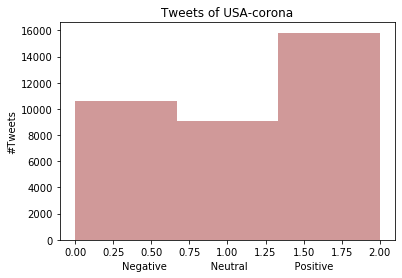

In [26]:
# Bargraph of Sentiment
sents =[]
for tw in data.Fully_cleaned_tweets:
    st = sentiment_analyzer_scores(tw)
    sents.append(st)
ax = sns.distplot(sents,kde=False,bins=3,color='darkred')
ax.set(xlabel='Negative              Neutral               Positive',ylabel='#Tweets',title="Tweets of USA-corona")

In [27]:
from collections import Counter

def con(sentence):
    emotion_list = []
    sentence = sentence.split(' ')
    with open('emotions.txt','r') as file:
        for line in file:
            clear_line = line.replace("\n", '').replace(",",'').replace("'",'').strip()
            word, emotion = clear_line.split(':')

            if word in sentence:
                emotion_list.append(emotion)
        w = Counter(emotion_list)
        return w
    

In [28]:
data['emotion'] = data['Fully_cleaned_tweets'].apply(lambda x: con(x) )

In [29]:
data.head(10)

,text,username,location,len,clean,cleant,text_Token,sentiment,Fully_cleaned_tweets,emotion
0,@manychat Partners with Centers for Disease Co...,MarTechSeries,"Hawthorne, CA",166,Partners with Centers for Disease Control and...,Partners Centers Disease Control Prevention Ed...,[],1,partner center disease control prevention educ...,{}
1,Tomorrow on Surviving Lockdown. The story of a...,MarkRyesMedia,"Bicester, England",302,Tomorrow on Surviving Lockdown The story of a ...,Tomorrow Surviving Lockdown The story successf...,"[w, w, w, w]",2,tomorrow surviving lockdown the story successf...,{}
2,Covid-19 was originally released to quell the ...,cbbboston,"Moonracer, Island",264,Covid was originally released to quell the Chi...,Covid19 originally released quell Chinese popu...,[w],0,covid originally released quell chinese popula...,{' free': 1}
3,The efficient leader #Mamata Banerjee is tryi...,banglar_mamata,Kolkata,167,The efficient leader Mamata Banerjee is tryin...,The efficient leader Mamata Banerjee trying be...,[],2,the efficient leader mamata banerjee trying be...,{}
4,@RajuBistaBJP @COVIDNewsByMIB\n@SiliguriPolice...,abhishekzPASWAN,"Siliguri, India (West Bengal)",243,Safe Keep DistanceCovidSiliguri reports n...,Safe 🙏Keep DistanceCovid19Siliguri reports 2 n...,[w],2,safe keep distancecovidsiliguri report new cas...,{}
5,RT @fitrasetiawan16: indonesia are fighting 2 ...,kurrniawanirvan,Subang - Bogor - Kudus,124,indonesia are fighting pandemics COVID amp S...,indonesia fighting 2 pandemics COVID19 amp STU...,[],0,indonesia fighting pandemic covid amp stupidit...,{}
6,RT @anandMenon1: I missed this excoriating pie...,LBM87,"Grantham, UK",129,I missed this excoriating piece yesterday fro...,I missed excoriating piece yesterday care home...,[w],2,i missed excoriating piece yesterday care home...,{}
7,RT @newscientist: Covid-19 pandemic risks wors...,Schakofterick,Extremo Sul - Brasil,125,Covid pandemic risks worst global food crisis...,Covid19 pandemic risks worst global food crisi...,[w],0,covid pandemic risk worst global food crisis d...,{}
8,Arsenicum Album 30 and Camphora 1m: What Are T...,latestly,"Mumbai, India",257,Arsenicum Album and Camphoram What Are These ...,Arsenicum Album 30 Camphora1m What Are These H...,[w],2,arsenicum album camphoram what are these homeo...,{}
9,COVID-19 Impact on Gas Sensors Market – Exclus...,feed_stocks,"Florida, USA",102,COVID Impact on Gas Sensors Market Exclusive ...,COVID19 Impact Gas Sensors Market – Exclusive ...,[],2,covid impact gas sensor market exclusive repor...,{}


In [30]:
emo=con(data['Fully_cleaned_tweets'].sum())

In [31]:
data['text'][8]

"Arsenicum Album 30 and Camphora 1m: What Are These Homeopathic Immunity Boosters Recommended by Ministry of AYUSH Amid COVID-19 Pandemic? Here's Everything You Need to Know\n#ArsenicumAlbum30 #Camphora1m\n#MinistryofAYUSH #Homeopathy \n\nhttps://t.co/b2DrdWYT60"

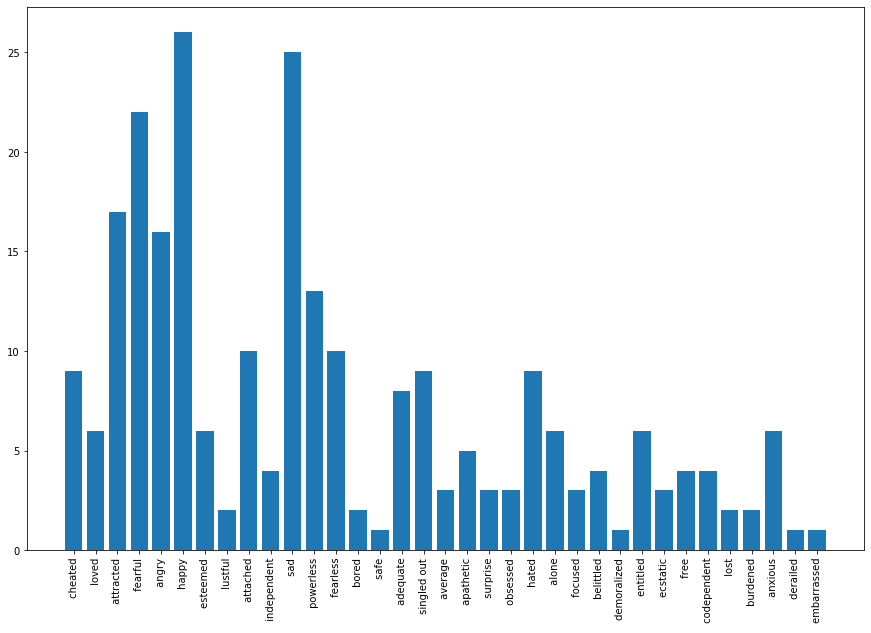

In [32]:
plt.figure(figsize = (15,10))
plt.bar(emo.keys(),emo.values())
plt.xticks(rotation = 90)
plt.show()

In [33]:
#WordCloud
def generate_wordcloud(all_words):
    Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))
    image_colors = ImageColorGenerator(Mask)
    wc = WordCloud(background_color='black', height=750, width=2000,mask=Mask).generate(all_words)
    plt.figure(figsize=(10,20))
    plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")
    plt.axis('off')
    plt.show()

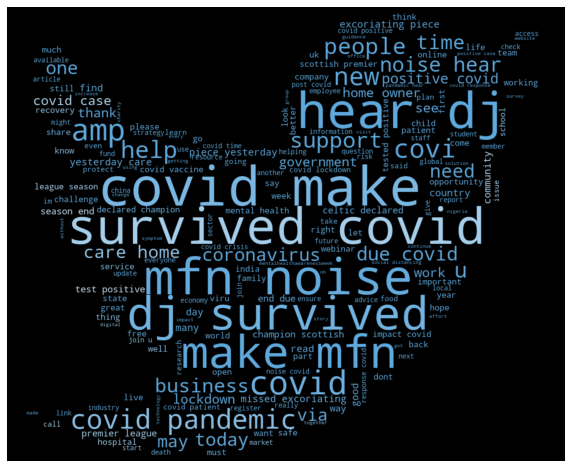

In [34]:
#WordCloud for the Positive Sentiment
all_words = ' '.join([text for text in data['Fully_cleaned_tweets'][data.sentiment == 2]])
generate_wordcloud(all_words)

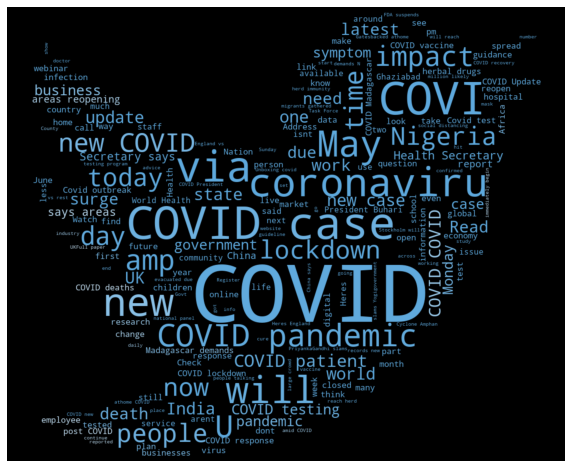

In [35]:
#WordCloud for Neutral Sentiment
all_words = ' '.join([text for text in data['clean'][data.sentiment == 1]])
generate_wordcloud(all_words)

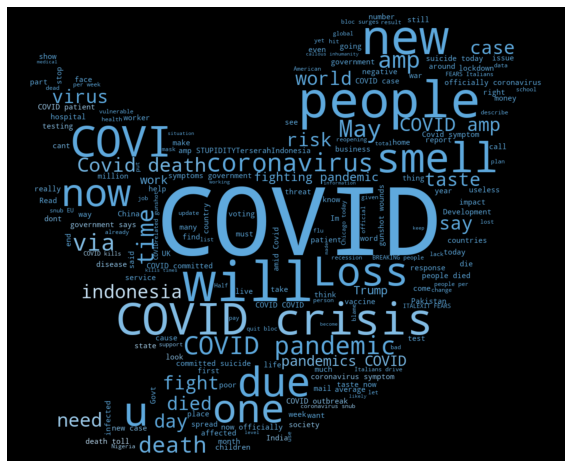

In [36]:
#Wordcloud for Negative Sentiment
all_words = ' '.join([text for text in data['clean'][data.sentiment == 0]])
generate_wordcloud(all_words)

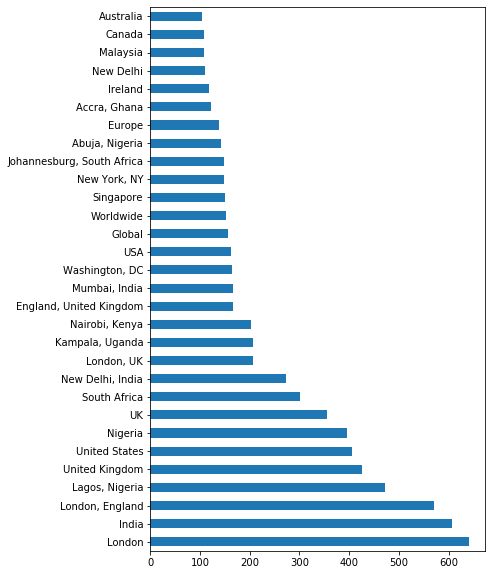

In [37]:
#Tweets Location Graph
data['location'].value_counts().head(30).plot(kind='barh', figsize=(6,10))

In [38]:
#Inserting X and Y From Dataset
x = data.iloc[:,-2].values
y = data.iloc[:,-3].values

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
x = tfidf_word_vectorizer.fit_transform(x)

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [41]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [42]:
#Validate the Model Created
predictions = classifier.predict(X_test.toarray())

In [43]:
file_name='TestTweet.csv'
test=pd.read_csv(file_name) 

In [44]:
test['clean']=clean_tweets(test['text']) 
test['clean']=test['clean'].str.replace("[^a-zA-Z ]", " ")

In [45]:
for i,tweet in enumerate(test['clean']):
    op=classifier.predict(tfidf_word_vectorizer.transform([tweet]).toarray())
    if op == [0]:
        print(i,")"," ' ",test.text[i]," ' ",'\n','=','NEGATIVE','\n')
    if op == [1]:
        print(i,")"," ' ",test.text[i]," ' ",'\n','=','NEUTRAL','\n')
    if op == [2]:
        print(i,")"," ' ",test.text[i]," ' ",'\n','=','POSITIVE','\n')

0 )  '  RT @djnicholl: Show us proof that Johnson is following science, MPs urge 

https://t.co/aN9ofVaQBV  '  
 = NEUTRAL 

1 )  '  Why people think 5G responsible for coronavirus https://t.co/jloVJuO0G0 via @YouTube  '  
 = NEUTRAL 

2 )  '  Yesterday I was walking along a pier of the #Amsterdam Oude Houthaven when an angry houseboat resident invited me leave as "they don't like walkers due to the #coronavirus" WTF...  '  
 = POSITIVE 

3 )  '  RT @WyeLea: The coronavirus crisis must not be allowed to delay Brexit https://t.co/4n6mip2MVg  '  
 = NEGATIVE 

4 )  '  #N4P #C4XD #IQAI 
Coronavirus: Moderna’s US vaccine first trials show immune response https://t.co/2vy25EMqEY  '  
 = NEUTRAL 

5 )  '  @HeshmatAlavi China knew what they were doing as soon as President Trump signed those papers. China will fulfill their deal as long as no pandemic happens. TWO days later &amp; here is Coronavirus knocking at our doors! Sue them, I say.  '  
 = NEGATIVE 

6 )  '  RT @jonworth: Even by Brexi

47 )  '  The latest on the coronavirus outbreak with Bobby @bobbyisawake &amp; Stacy @Livviesmomma -
✅DeWine: Bar owners could lose their liquor licenses if they don’t control their customers
✅Experimental vaccine shows encouraging results
✅Trump taking hydroxychloroquine https://t.co/rAhIv5Wmki  '  
 = NEGATIVE 

48 )  '  RT @RealJamesWoods: And if not, CNN will do everything it can to get us there...  https://t.co/tXG0u7XFKO  '  
 = NEUTRAL 

49 )  '  @WyeLea Agreed 100% Let's face it, we are already in a situation of a severe downturn due to the Coronavirus. The remainer argument about supply chains won't matter as we are already badly affected (for now). So we may as leave as things cannot get any worse, only much better.  '  
 = POSITIVE 

50 )  '  RT @EaterSouls: 72 people test positive for coronavirus after mass lockdown protest in Wisconsin https://t.co/CDzqAt6aAw  '  
 = POSITIVE 

51 )  '  Joining @SeneddCWLC is Nick Capaldi, Chief Executive @Arts_Wales_. Giving evidence on b

96 )  '  RT @nousha_mohd: Zee News: Noida's most deadly coronavirus hotspot.@ZeeNews 

#ZeeNewsSealKaro https://t.co/jzi3RbqIQy  '  
 = NEUTRAL 

97 )  '  @DrHilaryJones If people who receive the vaccine are not exposed to Coronavirus how do we know how well it works &amp; whether the vaccine makes the symptoms worse..? Thank you  '  
 = POSITIVE 

98 )  '  #Uber to cut 3,000 more jobs as #coronavirus crisis rises 

#layoffs #Jobs #lockdown #COVID19 

https://t.co/2tX3WUZxSo  '  
 = NEGATIVE 

99 )  '  Cannabis extracts may help to prevent coronavirus, study suggests https://t.co/8kCRJXEIez #CannabisNews #Cannabis  '  
 = POSITIVE 

100 )  '  During these uncertain times, many of us will be worried about how we manage our rent 🏠 

We are here to help you
Talk to us 💬

The following organisations have guidance on how Coronavirus may affect income &amp; benefits ⬇️

🟡 @DWP 
🟠 @CitizensAdvice 
🟢 @YourMoneyAdvice https://t.co/VRhGlbZT4n  '  
 = POSITIVE 

101 )  '  The Government has issue

143 )  '  Commentary: Past pandemics changed the design of cities. Six ways COVID-19 could do the same https://t.co/EdJWLMXdtB  '  
 = NEUTRAL 

144 )  '  RT @MiamiHerald: Florida’s COVID-19 website guru blasts bosses, hints at data suppression. https://t.co/16sva7VeW0  '  
 = NEUTRAL 

145 )  '  Australia and China spat over coronavirus inquiry deepens https://t.co/2dfTxGdWWE  '  
 = NEUTRAL 

146 )  '  China stole a patent from a US company conducting trials in Wuhan the early days of the outbreak. China/CCP spread the virus, they should be liable for damages. Not only free vaccines, but more.

(I doubt China's vaccines will work tho lol)

https://t.co/Gcxyw3kC1O  '  
 = POSITIVE 

147 )  '  BMJ damns UK government for mishandling coronavirus outbreak and ignoring science.
Too damn late now, the damage has been done and the human cost is high.

https://t.co/HKnPHrN6uW  '  
 = NEGATIVE 

148 )  '  RT @Pun_Starr: I think BJP leaders should most beware of Zee News journalists. Coronavir

189 )  '  China’s Unrestricted Warfare Could Lead to Collapse in One Year https://t.co/9BKOrZiF8Y via @YouTube
#CCPvirus #WakeUpAmerica #ResistTyranny #StandUpToEvil #COVID19 #Coronavirus #NoWorldOrder #SpyState #ContactTracing  '  
 = NEUTRAL 

190 )  '  Phone calls offered to older adults staying home during coronavirus pandemic https://t.co/Kc6xLZaW2h  '  
 = NEUTRAL 

191 )  '  @ai6yrham forced to have implanted microchips by Bill Gates." Change the subject from coronavirus to whatever other subject and you will find people in psych wards across the USA hospitalized for saying very similar things. We call this paranoia and delusions. It is a significant mental  '  
 = NEGATIVE 

192 )  '  As the first tragic images of the UK’s coronavirus victims began to emerge, it quickly became evident the lives being lost were disproportionately those from black, Asian, and minority ethnic (BAME) communities.
 https://t.co/SHGWxKjAWo  '  
 = NEGATIVE 

193 )  '  .@matthewsyed on effects of grou

In [46]:
#Testing Our Model

tweet="@briantylercohen Hey #Insane @realDonaldTrump $@@&% ! Are //$* you crazy? ANY of them don't need to die at all..."
clean=clean_tweets(tweet)
clean=str(clean)
clean=re.sub('[^a-zA-Z]', ' ',clean )
text=clean
clean=[clean]

In [47]:
from nltk.tokenize import RegexpTokenizer,word_tokenize
word_tokenize(text)

['Hey',
 'Insane',
 'Are',
 'you',
 'crazy',
 'ANY',
 'of',
 'them',
 'don',
 't',
 'need',
 'to',
 'die',
 'at',
 'all']

In [48]:
op=classifier.predict(tfidf_word_vectorizer.transform(clean).toarray())
if op == [0]:
    print(tweet,'\n','=','NEGATIVE','\n')
if op == [1]:
    print(tweet,'\n','=','NEUTRAL','\n')
if op == [2]:
    print(tweet,'\n','=','POSITIVE','\n')

@briantylercohen Hey #Insane @realDonaldTrump $@@&% ! Are //$* you crazy? ANY of them don't need to die at all... 
 = NEGATIVE 



In [49]:
#Accuracy Of Our Model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('Accuracy score : ',accuracy_score(y_test, predictions)*100,'\n')

Accuracy score :  83.42961814851346 



In [50]:
print(confusion_matrix(y_test,predictions),'\n')

[[1509  233  317]
 [  74 1649  171]
 [ 128  253 2763]] 



In [51]:
#saving the Prediction Model
import pickle

In [52]:
with open('Sentiment_Model','wb') as f:
    pickle.dump(classifier,f)

In [53]:
with open('Sentiment_Model','rb') as f:
    model=pickle.load(f)

In [1]:
text='I am depressed'
clean=clean_tweets(text)
clean=str(clean)
clean=re.sub('[^a-zA-Z]', ' ',clean )
clean=[clean]


NameError: name 'clean_tweets' is not defined

In [58]:
op=classifier.predict(tfidf_word_vectorizer.transform(clean).toarray())
if op == [0]:
    print(text,'\n','=','NEGATIVE','\n')
if op == [1]:
    print(text,'\n','=','NEUTRAL','\n')
if op == [2]:
    print(text,'\n','=','POSITIVE','\n')

I am Sad 
 = NEGATIVE 

